# Credit Card Fraud Detection - Model Development

## Objectives
- Build robust classical ML models for fraud detection
- Handle severe class imbalance
- Optimize for business metrics
- Compare multiple algorithms - Logistic Regression, Decision Tree, Random Forest, SVM (dropped SVM after understanding the limitations)
- Deploy best model with proper evaluation

## Challegnes identified from EDA
- Severe class imbalance
- PCA transformed features limit interpretability of data

In [1]:
# import libraries

# Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Cross validation libraries
from sklearn.model_selection import RandomizedSearchCV

# Metric libraries
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve,
                             average_precision_score,
                             confusion_matrix,precision_recall_curve)

# Libraries to handle imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTETomek

# Libraries for model development
from sklearn.utils.class_weight import compute_class_weight

# Miscellaneous Libraries
import json
import warnings
warnings.filterwarnings("ignore")
import joblib

print("Required libraries imported successfully!")

Required libraries imported successfully!


In [2]:
# Load dataset and insights from EDA
df = pd.read_csv('../data/creditcard.csv')
insights = json.load(open('../data/eda_insights.json'))

print("Dataset and insights loaded successfully!")

Dataset and insights loaded successfully!


In [3]:
# Extract key insights
with open('../data/eda_insights.json', 'r') as f:
    insights = json.load(f)

print("=== KEY INSIGHTS FROM EDA ===")
# Display insights
for key, value in insights.items():
    print(f"{key}: {value}")

=== KEY INSIGHTS FROM EDA ===
memory_usage_mb: 67.36
dataset_shape: [284807, 32]
imbalance_ratio: 577.88
fraud_rate: 0.17
missing_values: {}
duplicates_percentage: 0.379555277784605
top_15_features: ['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18', 'V1', 'V9', 'V5', 'V2', 'V6']
significant_features: ['V14', 'V4', 'V12', 'V11', 'V10', 'V3', 'V2', 'V16', 'V9', 'V7', 'V17', 'V1', 'V6', 'V21', 'V18', 'V5', 'V27', 'V8', 'V19', 'V20', 'V28', 'Time', 'V24', 'Amount']
amount_stats: {'legitimate_mean': 88.29102242231328, 'fraudulent_mean': 122.21132113821139, 'max_transaction_amount': 25691.16, 'min_transaction_amount': 0.0, 'amount_std': 250.1201092401885}


In [4]:
# Feature preperation
print("=== FEATURE PREPARATION ===")

# Split dataset into features and target
X = df.drop(columns=['Class'])
y = df['Class']
print("\nFeatures and target variable separated successfully!")

# Consider only top 15 features based on EDA insights
top_features = insights['top_15_features']
X_selected = X[top_features]
print(f"\nSelected top {len(top_features)} features for modelling.")
print(f"\nSelected features: {', '.join(feature for feature in top_features)}")

=== FEATURE PREPARATION ===

Features and target variable separated successfully!

Selected top 15 features for modelling.

Selected features: V17, V14, V12, V10, V16, V3, V7, V11, V4, V18, V1, V9, V5, V2, V6


In [5]:
# Time based train-test split
print("\n=== TIME BASED TRAIN-TEST SPLIT ===")

# sort by 'Time' to ensure temporal order
df_sorted = df.sort_values(by='Time').reset_index(drop=True)
X_sorted = df_sorted[top_features]
y_sorted = df_sorted['Class']
print("\nDataset sorted by 'Time' for temporal split.")

# Split into train and test sets (First 80% train, Last 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_sorted, y_sorted, test_size=0.2, shuffle=False)
print("\nTrain-test split completed successfully!")

# print shapes of train and test sets
print(f"\nTrain set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Train fraud rate: {y_train.mean() * 100:.2f}%, Test fraud rate: {y_test.mean() * 100:.2f}%")


=== TIME BASED TRAIN-TEST SPLIT ===

Dataset sorted by 'Time' for temporal split.

Train-test split completed successfully!

Train set shape: (227845, 15), Test set shape: (56962, 15)
Train fraud rate: 0.18%, Test fraud rate: 0.13%


In [6]:
# Feature scaling
print("\n=== FEATURE SCALING ===")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\nFeature scaling completed using RobustScaler!")


=== FEATURE SCALING ===

Feature scaling completed using RobustScaler!


In [7]:
# Handling class imbalance
print("\n=== HANDLING CLASS IMBALANCE ===")

datapoints_number = {}

# Stratergy 1: Original class distribution
print("\nStrategy 1: Original class distribution")
print(f"Legitimate: {len(y_train[y_train==0])} ({len(y_train[y_train==0]) / len(y_train) * 100:.2f}%)")
print(f"Fraudulent: {len(y_train[y_train==1])} ({len(y_train[y_train==1]) / len(y_train) * 100:.2f}%)")
# display(len(y_train[y_train==0]))
datapoints_number['original'] = {
    'Legitimate': len(y_train[y_train==0]),
    'Fraudulent': len(y_train[y_train==1])
}

# Stratergy 2: SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("\nStrategy 2: SMOTE applied")
print(f"Legitimate: {len(y_train_smote[y_train_smote==0])} ({len(y_train_smote[y_train_smote==0]) / len(y_train_smote) * 100:.2f}%)")
print(f"Fraudulent: {len(y_train_smote[y_train_smote==1])} ({len(y_train_smote[y_train_smote==1]) / len(y_train_smote) * 100:.2f}%)")
datapoints_number['smote'] = {
    'Legitimate': len(y_train_smote[y_train_smote==0]),
    'Fraudulent': len(y_train_smote[y_train_smote==1])
}

# Stratergy 3: Borderline SMOTE
borderline_smote = BorderlineSMOTE(random_state=42, k_neighbors=5)

X_train_borderline_smote, y_train_borderline_smote = borderline_smote.fit_resample(X_train_scaled, y_train)
print("\nStrategy 3: Borderline SMOTE applied")
print(f"Legitimate: {len(y_train_borderline_smote[y_train_borderline_smote==0])} ({len(y_train_borderline_smote[y_train_borderline_smote==0]) / len(y_train_borderline_smote) * 100:.2f}%)")
print(f"Fraudulent: {len(y_train_borderline_smote[y_train_borderline_smote==1])} ({len(y_train_borderline_smote[y_train_borderline_smote==1]) / len(y_train_borderline_smote) * 100:.2f}%)")
datapoints_number['borderline_smote'] = {
    'Legitimate': len(y_train_borderline_smote[y_train_borderline_smote==0]),
    'Fraudulent': len(y_train_borderline_smote[y_train_borderline_smote==1])
}

# Stratergy 4: Undersampling + SMOTE combination
smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train_scaled, y_train)
print("\nStrategy 3: Undersampling + SMOTE applied")
print(f"Legitimate: {len(y_train_smote_tomek[y_train_smote_tomek==0])} ({len(y_train_smote_tomek[y_train_smote_tomek==0]) / len(y_train_smote_tomek) * 100:.2f}%)")
print(f"Fraudulent: {len(y_train_smote_tomek[y_train_smote_tomek==1])} ({len(y_train_smote_tomek[y_train_smote_tomek==1]) / len(y_train_smote_tomek) * 100:.2f}%)")
datapoints_number['smote_tomek'] = {
    'Legitimate': len(y_train_smote_tomek[y_train_smote_tomek==0]),
    'Fraudulent': len(y_train_smote_tomek[y_train_smote_tomek==1])
}
with open('../data/imbalance_handling_strategies.json', 'w') as f:
    json.dump(datapoints_number, f, indent=2)



=== HANDLING CLASS IMBALANCE ===

Strategy 1: Original class distribution
Legitimate: 227428 (99.82%)
Fraudulent: 417 (0.18%)

Strategy 2: SMOTE applied
Legitimate: 227428 (50.00%)
Fraudulent: 227428 (50.00%)

Strategy 3: Borderline SMOTE applied
Legitimate: 227428 (50.00%)
Fraudulent: 227428 (50.00%)

Strategy 3: Undersampling + SMOTE applied
Legitimate: 227428 (50.00%)
Fraudulent: 227428 (50.00%)


In [14]:
# Model Development using samples from different stratergies
print("=== MODEL DEVELOPMENT ===")

# Compute class weights for cost-sensitive learning
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = np.unique(y_train),
                                     y = y_train)
# display(class_weights)
class_weights_dict = {0: class_weights[0].round(2), 1: class_weights[1].round(2)}
print(f"\nComputed Class weights!")
print(f"Class weights: {class_weights_dict}")

# define models
models = {
    'Logistic Regression' : LogisticRegression(
        random_state = 42,
        class_weight = 'balanced',
        max_iter = 1000
    ),
    'Decision Tree' : DecisionTreeClassifier(
        random_state = 42,
        class_weight = 'balanced',
        max_depth = 10,
        min_samples_split = 100,
        min_samples_leaf = 50
    ),
    'Random Forest' : RandomForestClassifier(
        n_estimators = 100,
        random_state = 42,
        class_weight = 'balanced',
        max_depth = 10,
        min_samples_split = 100,
        min_samples_leaf = 50,
        n_jobs = -1
    )#,
    # 'SVM' : SVC(
    #     random_state = 42,
    #     class_weight = 'balanced',
    #     kernel = 'rbf',
    #     probability = True
    # )

    # Ignoring SVM
}

print(f"\nInitialized {len(models)} classical ML models.")

=== MODEL DEVELOPMENT ===

Computed Class weights!
Class weights: {0: np.float64(0.5), 1: np.float64(273.2)}

Initialized 3 classical ML models.


### Important:

Ignored SVM because:
- The data obtained from oversampling techniques is really really huge, around 2.5lakh datapoints for 31 variables for each class.
- Running an SVM on such large dataset, that too with RBF Kernel, for 5 Fold Cross Validation is computationally intensive
- Initially, I hadn't thought about this - ran the model, but even after 9 hours of training, I couldn't complete 5 Fold CV using SVM for data from SMOTE oversampling.
- This lead me to realise that it was an impractical approach, hence cancelling the training task late at night.
- Key takeaway from this mistake is that - using SVM on really large datasets like this one is not favourable.
- So I will be continuing with only 3 models - Logistic Regression, Decision Tree and Random Forests.

In [9]:
# Initiate Cross Validation to ensure stable and reliable results
print("=== CROSS VALIDATION SETUP ===")

# Initiate Stratified K Fold Cross Validation (maintains class distribution)
k = 5
cv_stratergy = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# define a function to get CV performance metrics
def evaluate_model_cv(model, X, y, cv_stratergy, scoring_metrics):
    results = {}
    for metric in scoring_metrics:
        scores = cross_val_score(model, X, y, cv = cv_stratergy, scoring = metric, n_jobs = -1)
        results[metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
    return results

# list out scoring metrics appropriate for imbalanced datasets
scoring_metrics = ['precision', 'recall', 'f1', 'roc_auc', 'average_precision']

print("\nCross validation strategy configured!")
print(f"Used Stratified {k} fold cross validation with metrics {scoring_metrics}")


=== CROSS VALIDATION SETUP ===

Cross validation strategy configured!
Used Stratified 5 fold cross validation with metrics ['precision', 'recall', 'f1', 'roc_auc', 'average_precision']


In [15]:
# Model Training and Evaluation
print("=== MODEL TRAINING AND EVALUATION ===")

# store results from different models
results_comparision = {}

# different sampling strategies
sampling_strategies = {
    'Original': (X_train_scaled, y_train),
    'SMOTE': (X_train_smote, y_train_smote),
    'Borderline_SMOTE': (X_train_borderline_smote, y_train_borderline_smote),
    'SMOTE_Tomek': (X_train_smote_tomek, y_train_smote_tomek)
}

# run a loop for all the strategies and for all the models
for strategy, (X_train, y_train) in sampling_strategies.items():
    print(f"\n=== EVALUATING WITH {strategy.upper()} STRATEGY ===")
    
    results_comparision[strategy] = {}

    # evaluate for each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")

        # evaluate CV results
        cv_results = evaluate_model_cv(model, X_train, y_train, cv_stratergy, scoring_metrics)
        results_comparision[strategy][model_name] = cv_results

        # print results
        print(f"\nModel: {model_name}")
        for metric,values in cv_results.items():
            print(f"Metric: {metric} : {values['mean']:.4f} ({values['std']:.4f})")

=== MODEL TRAINING AND EVALUATION ===

=== EVALUATING WITH ORIGINAL STRATEGY ===

Training Logistic Regression...

Model: Logistic Regression
Metric: precision : 0.0672 (0.0016)
Metric: recall : 0.8970 (0.0315)
Metric: f1 : 0.1251 (0.0029)
Metric: roc_auc : 0.9732 (0.0075)
Metric: average_precision : 0.7288 (0.0184)

Training Decision Tree...

Model: Decision Tree
Metric: precision : 0.1089 (0.0244)
Metric: recall : 0.8512 (0.0228)
Metric: f1 : 0.1923 (0.0391)
Metric: roc_auc : 0.9243 (0.0118)
Metric: average_precision : 0.7332 (0.0529)

Training Random Forest...

Model: Random Forest
Metric: precision : 0.7153 (0.0355)
Metric: recall : 0.8538 (0.0173)
Metric: f1 : 0.7779 (0.0235)
Metric: roc_auc : 0.9771 (0.0089)
Metric: average_precision : 0.8005 (0.0149)

=== EVALUATING WITH SMOTE STRATEGY ===

Training Logistic Regression...

Model: Logistic Regression
Metric: precision : 0.9736 (0.0008)
Metric: recall : 0.8989 (0.0011)
Metric: f1 : 0.9348 (0.0005)
Metric: roc_auc : 0.9836 (0.0006)

In [372]:
# exporting all the metrics calculated above to a json file for future reference
def convert_ndarray(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    if isinstance(obj, dict):
        return {k: convert_ndarray(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_ndarray(v) for v in obj]
    return obj

with open('../performance-measures/cv_metrics_data.json', 'w') as f:
    json.dump(convert_ndarray(results_comparision), f, indent=2)

The training for SVM has taken too long, about 9 hours till now to run cross validation for SMOTE dataset with SVM. This proves the fact that SVM is not efficient of preferable for large dataset with very high dimension. So it's better to ignore SVM in such cases.

In [350]:
# print(results_comparision)
results_comparision_df = pd.DataFrame(results_comparision)
print(results_comparision_df)

# exporting the results temproarily to a csv file
results_comparision_df.to_csv("results_comparision.csv")

                                                              Original  \
Logistic Regression  {'precision': {'mean': 0.0672375375627486, 'st...   
Decision Tree        {'precision': {'mean': 0.10890828802041903, 's...   
Random Forest        {'precision': {'mean': 0.7152622340223418, 'st...   

                                                                 SMOTE  \
Logistic Regression  {'precision': {'mean': 0.9736449253928405, 'st...   
Decision Tree        {'precision': {'mean': 0.9851391349573069, 'st...   
Random Forest        {'precision': {'mean': 0.9962638741293471, 'st...   

                                                      Borderline_SMOTE  \
Logistic Regression  {'precision': {'mean': 0.9885579243902225, 'st...   
Decision Tree        {'precision': {'mean': 0.9979410419166135, 'st...   
Random Forest        {'precision': {'mean': 0.9991562304552449, 'st...   

                                                           SMOTE_Tomek  
Logistic Regression  {'precision': {

In [16]:
# Continuing with the workflow today!

In [17]:
print(results_comparision)

{'Original': {'Logistic Regression': {'precision': {'mean': np.float64(0.0672375375627486), 'std': np.float64(0.0016170209137248259), 'scores': array([0.06636364, 0.06875544, 0.06465517, 0.06906077, 0.06735267])}, 'recall': {'mean': np.float64(0.8969879518072288), 'std': np.float64(0.031492715241939535), 'scores': array([0.87951807, 0.95180723, 0.90361446, 0.89285714, 0.85714286])}, 'f1': {'mean': np.float64(0.12508685990007395), 'std': np.float64(0.002898247809637607), 'scores': array([0.12341505, 0.12824675, 0.12067578, 0.12820513, 0.12489159])}, 'roc_auc': {'mean': np.float64(0.9731744792796272), 'std': np.float64(0.00749930278545217), 'scores': array([0.96614263, 0.98518517, 0.96592914, 0.97028089, 0.97833456])}, 'average_precision': {'mean': np.float64(0.7288392286650859), 'std': np.float64(0.018390142658239066), 'scores': array([0.74340734, 0.73931366, 0.73986691, 0.69352837, 0.72807986])}}, 'Decision Tree': {'precision': {'mean': np.float64(0.10890828802041903), 'std': np.float6

In [20]:
# Results Visualization
print("=== RESULTS VISUALIZATION ===")

# Create a dataframe to visualize the results
results_df = []
for strategy in results_comparision:
    for model in results_comparision[strategy]:
        for metric in results_comparision[strategy][model]:
            results_df.append(
                {
                    'Strategy': strategy,
                    'Model': model,
                    'Metric': metric,
                    'Score': results_comparision[strategy][model][metric]['mean'],
                    'Std': results_comparision[strategy][model][metric]['std']
                }
            )
results_df = pd.DataFrame(results_df)
display(results_df)

=== RESULTS VISUALIZATION ===


,Strategy,Model,Metric,Score,Std
0,Original,Logistic Regression,precision,0.067238,0.001617
1,Original,Logistic Regression,recall,0.896988,0.031493
2,Original,Logistic Regression,f1,0.125087,0.002898
3,Original,Logistic Regression,roc_auc,0.973174,0.007499
4,Original,Logistic Regression,average_precision,0.728839,0.018390
5,Original,Decision Tree,precision,0.108908,0.024362
6,Original,Decision Tree,recall,0.851234,0.022800
7,Original,Decision Tree,f1,0.192300,0.039150
8,Original,Decision Tree,roc_auc,0.924290,0.011779
9,Original,Decision Tree,average_precision,0.733235,0.052927


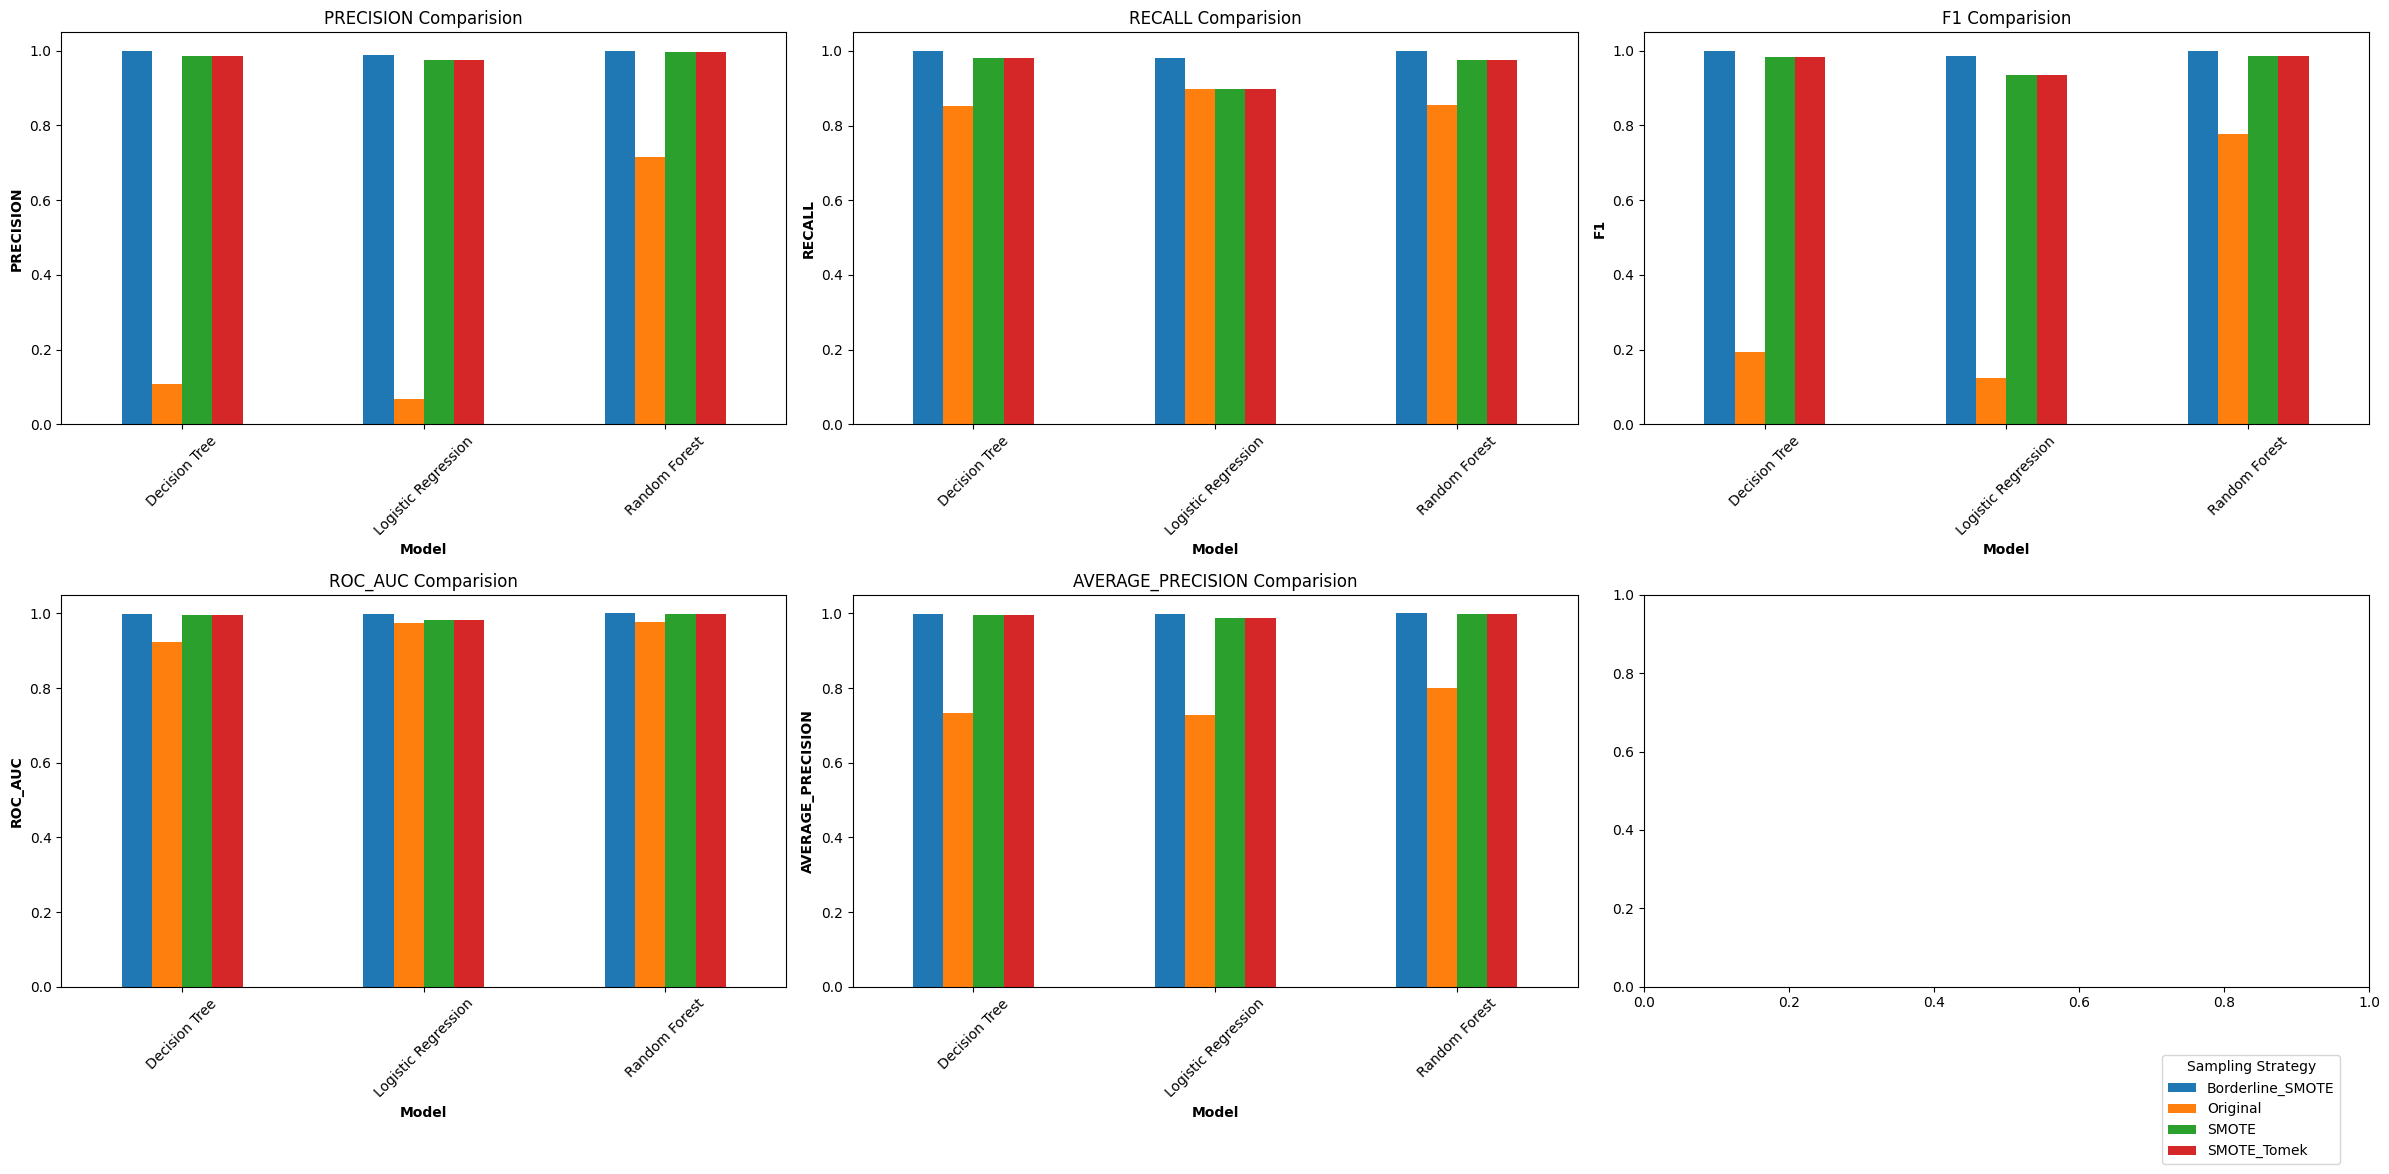

In [ ]:
# Plot for visualization
fig,axes = plt.subplots(2,3,figsize=(24,12))

metrics_to_plot = ['precision','recall','f1','roc_auc','average_precision']

for i,metric in enumerate(metrics_to_plot):
    pivot_data = results_df[results_df['Metric'] == metric].pivot(
            index='Model', columns='Strategy', values='Score'
        )
    # display(pivot_data)
    pivot_data.plot(kind='bar', ax = axes[i//3, i%3], title = f"{metric.upper()} Comparision",legend=False)
    axes[i//3, i%3].set_xlabel("Model",fontweight="bold")
    axes[i//3, i%3].set_ylabel(metric.upper(),fontweight="bold")
    # axes[i//3, i%3].legend(title="Sampling Strategy",loc='upper left')
    axes[i//3, i%3].tick_params(axis = 'x', rotation=45)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title="Sampling Strategy", loc='lower right', bbox_to_anchor=(0.98, 0.02))
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [61]:
# pivot_data = results_df[results_df['Metric'] == 'f1'].pivot(
#             index='Model', columns='Strategy', values='Score'
#         )
# pivot_data

In [86]:
# Hyperparameter Tuning

print("=== HYPERPARAMETER TUNING ===")

# Select best performing strategy and model based on f1 score
f1_results = results_df[results_df['Metric']=='f1'].pivot(index = 'Model', columns = 'Strategy', values = 'Score')
f1_results = f1_results.round(4)
print("\nF1-Score Comparision across different strategies and models")
display(f1_results)

# extract best strategy and models
best_strategy = f1_results.mean().idxmax()
best_models = f1_results[best_strategy].nlargest(2).index.tolist()
print(f"Best Strategy: {best_strategy}")
print(f"Best {len(best_models)} Models: {', '.join(best_models)}")

print("\nGetting data for best strategy...")
X_best, y_best = sampling_strategies[best_strategy]

print("\nStarting Hyperparameter Tuning...")

# define hyperparameter grid

parameter_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [50, 100, 200],
        'min_samples_leaf': [25, 50, 100]
    },
    'Decision Tree': {
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [50, 100, 200],
        'min_samples_leaf': [25, 50, 100]
    }

    # defining hyperparameters only for these three models, the best 2 models selected previously will be considered for hyperparameter tuning

}

# tune hyperparameters

tuned_models = {}
tuned_params = {}
for model_name in best_models:
    if model_name in parameter_grids:
        print(f"\nTuning {model_name}...")

        # using randomized search CV
        base_model = models[model_name]

        random_search = RandomizedSearchCV(
            base_model,
            parameter_grids[model_name],
            n_iter = 10,
            cv = cv_stratergy,
            scoring = 'f1',
            n_jobs = -1,
            random_state = 42,
            verbose = 1
        )

        # fit a model using the tuned parameters
        random_search.fit(X_best, y_best)

        # push the models and parameters into variables (storing)
        tuned_models[model_name] = random_search.best_estimator_
        tuned_params[model_name] = random_search.best_params_

=== HYPERPARAMETER TUNING ===

F1-Score Comparision across different strategies and models


Strategy,Borderline_SMOTE,Original,SMOTE,SMOTE_Tomek
Model,,,,
Decision Tree,0.9987,0.1923,0.9828,0.9828
Logistic Regression,0.9853,0.1251,0.9348,0.9348
Random Forest,0.9994,0.7779,0.9851,0.9851


Best Strategy: Borderline_SMOTE
Best 2 Models: Random Forest, Decision Tree

Getting data for best strategy...

Starting Hyperparameter Tuning...

Tuning Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Tuning Decision Tree...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [375]:
# save hyperparameter tuning results into json file
# with open('../performance-measures/tuned_models.json', 'w') as f:
#     json.dump(convert_ndarray(tuned_models), f, indent=2)
with open('../performance-measures/tuned_params.json', 'w') as f:
    json.dump(convert_ndarray(tuned_params), f, indent=2)

In [93]:
# looking through the tuned_models and tuned_params
print("=== TUNED MODELS ===")
display(tuned_models)
print("="*100)
print("\n=== TUNED PARAMETERS ===")
display(tuned_params)

=== TUNED MODELS ===


{'Random Forest': RandomForestClassifier(class_weight='balanced', min_samples_leaf=25,
                        min_samples_split=50, n_estimators=200, n_jobs=-1,
                        random_state=42),
 'Decision Tree': DecisionTreeClassifier(class_weight='balanced', max_depth=15,
                        min_samples_leaf=50, min_samples_split=50,
                        random_state=42)}


=== TUNED PARAMETERS ===


{'Random Forest': {'n_estimators': 200,
  'min_samples_split': 50,
  'min_samples_leaf': 25,
  'max_depth': None},
 'Decision Tree': {'min_samples_split': 50,
  'min_samples_leaf': 50,
  'max_depth': 15}}

In [366]:
# Final model evaluation on test set
print("=== FINAL MODEL EVALUATION ON TEST SET ===")

# define evaluation function
def comprehensive_evaluation(model, X_test, y_test, model_name):

    # Predictions
    y_predicted = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Evaluation metrics
    precision = precision_score(y_test, y_predicted)
    recall = recall_score(y_test, y_predicted)
    f1 = f1_score(y_test, y_predicted)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    avg_precision = average_precision_score(y_test, y_prob) if y_prob is not None else None
    cm = confusion_matrix(y_test, y_predicted)

    # Print results
    print(f"\n==={model_name.upper()} TEST PERFORMANCE METRICS ===")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    if(roc_auc): print(f"ROC-AUC: {roc_auc}")
    if(avg_precision): print(f"Average Precision: {avg_precision}")
    print(f"\n=== CONFUSION MATRIX ===")
    # display(cm)
    print(f"TN: {cm[0,0]} FP: {cm[0,1]}")
    print(f"FN: {cm[1,0]} TP: {cm[1,1]}")

    # Calculate cost of misclassification
    cost_fp = 500
    cost_fn = 25

    total_cost = (cost_fp * cm[0,1]) + (cost_fn * cm[1,0])

    # print
    print(f"\n=== COST OF MISCLASSIFICATION ===")
    print(f"Cost of classifying legitimate transaction as fraudulent: {cost_fn * cm[1,0]}")
    print(f"Cost of classifying fraudulent transaction as legitimate: {cost_fp * cm[0,1]}")
    print(f"Total cost of misclassification: {total_cost}")

    # return the metrics and other essential information
    return {
        'Precision': precision,
        'Recall': recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
        "Average Precision": avg_precision,
        "Cost Matrix": cm,
        "Cost 1": cost_fn * cm[1,0],
        "Cost 2": cost_fp * cm[0,1],
        "Total Cost": total_cost
    }

# evaluate for each model
final_results = {}

for model_name,model in tuned_models.items():
    final_results[model_name] = comprehensive_evaluation(
        model,
        X_test_scaled,
        y_test,
        model_name
        )
    print("="*100)

print()
print("=== BASELINE MODELS EVALUATION ===")

baseline_model_results = {}
# extract best models
for model in best_models:
    baseline_model = models[model]
    baseline_model.fit(X_test, y_test)
    baseline_model_results[model] = comprehensive_evaluation(
        baseline_model,
        X_test_scaled,
        y_test,
        model
        )
    print("3")
display(baseline_model_results)


=== FINAL MODEL EVALUATION ON TEST SET ===

===RANDOM FOREST TEST PERFORMANCE METRICS ===
Precision: 0.7534246575342466
Recall: 0.7333333333333333
F1-Score: 0.7432432432432432
ROC-AUC: 0.9765664094315631
Average Precision: 0.7970459197873092

=== CONFUSION MATRIX ===
TN: 56869 FP: 18
FN: 20 TP: 55

=== COST OF MISCLASSIFICATION ===
Cost of classifying legitimate transaction as fraudulent: 500
Cost of classifying fraudulent transaction as legitimate: 9000
Total cost of misclassification: 9500

===DECISION TREE TEST PERFORMANCE METRICS ===
Precision: 0.375886524822695
Recall: 0.7066666666666667
F1-Score: 0.49074074074074076
ROC-AUC: 0.9036126590140687
Average Precision: 0.4472658566715607

=== CONFUSION MATRIX ===
TN: 56799 FP: 88
FN: 22 TP: 53

=== COST OF MISCLASSIFICATION ===
Cost of classifying legitimate transaction as fraudulent: 550
Cost of classifying fraudulent transaction as legitimate: 44000
Total cost of misclassification: 44550

=== BASELINE MODELS EVALUATION ===

===RANDOM 

{'Random Forest': {'Precision': 0.6931818181818182,
  'Recall': 0.8133333333333334,
  'F1-Score': 0.7484662576687117,
  'ROC-AUC': np.float64(0.9958043138151071),
  'Average Precision': np.float64(0.8180354075566645),
  'Cost Matrix': array([[56860,    27],
         [   14,    61]]),
  'Cost 1': np.int64(350),
  'Cost 2': np.int64(13500),
  'Total Cost': np.int64(13850)},
 'Decision Tree': {'Precision': 0.08533333333333333,
  'Recall': 0.8533333333333334,
  'F1-Score': 0.15515151515151515,
  'ROC-AUC': np.float64(0.9249050456753448),
  'Average Precision': np.float64(0.4452962474758142),
  'Cost Matrix': array([[56201,   686],
         [   11,    64]]),
  'Cost 1': np.int64(275),
  'Cost 2': np.int64(343000),
  'Total Cost': np.int64(343275)}}

=== FEATURE IMPORTANCE ANALYSIS ===

=== RANDOM FOREST ===
Top 10 important features for RANDOM FOREST:
   features  Importance
1       V14      0.2356
8        V4      0.1951
2       V12      0.1176
7       V11      0.1122
0       V17      0.0791
3       V10      0.0759
13       V2      0.0550
5        V3      0.0460
4       V16      0.0172
14       V6      0.0166

=== DECISION TREE ===
Top 10 important features for DECISION TREE:
   features  Importance
1       V14      0.7941
8        V4      0.0823
0       V17      0.0804
4       V16      0.0113
2       V12      0.0111
7       V11      0.0052
9       V18      0.0049
12       V5      0.0041
3       V10      0.0032
14       V6      0.0022


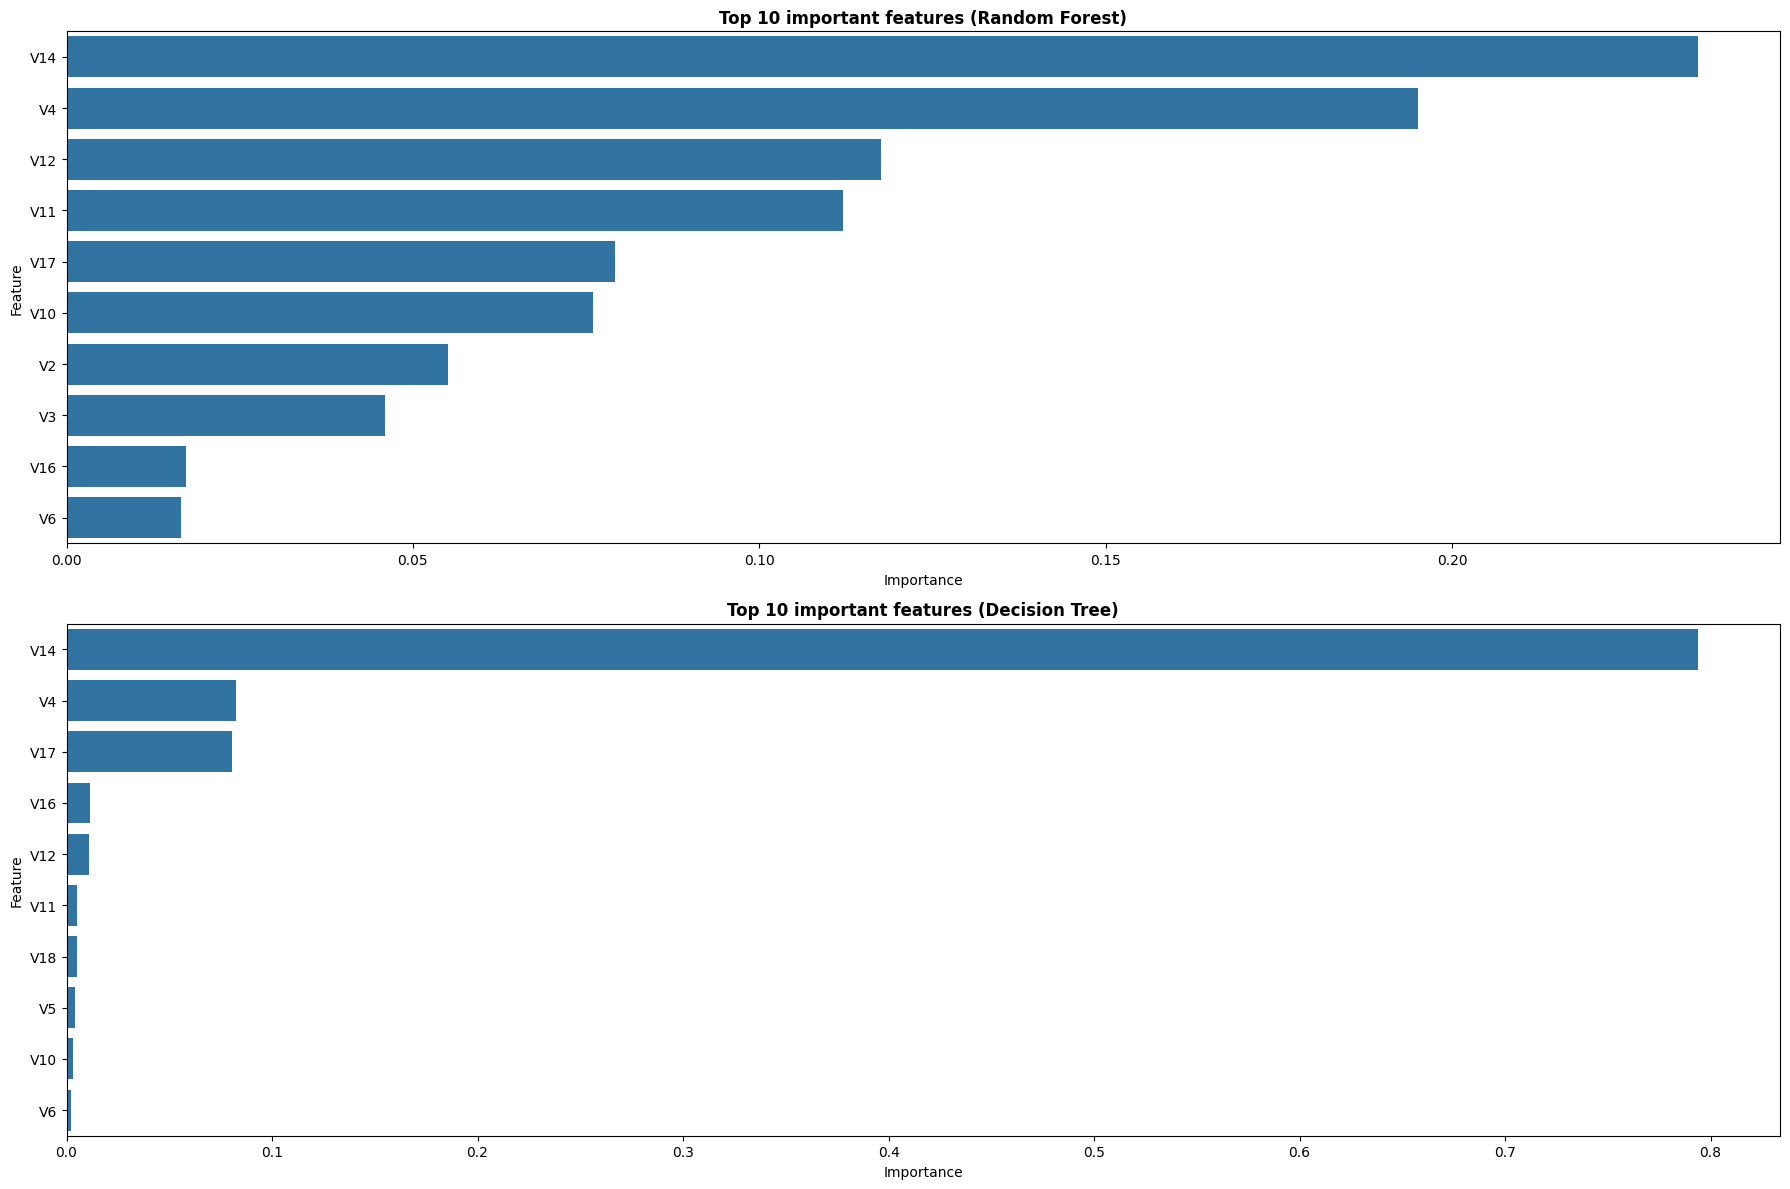

In [169]:
# Feature importance analysis
print("=== FEATURE IMPORTANCE ANALYSIS ===")

feature_importances = {}
# Get feature importance from tree based models
for model_name,model in tuned_models.items():
    if hasattr(model, 'feature_importances_'):
        print(f"\n=== {model_name.upper()} ===")
        importance_df = pd.DataFrame({
            'features': top_features,
            'Importance': model.feature_importances_,
            # 'model': model_name
        })
        feature_importances[model_name] = {
                'features': top_features,
                'Importance': model.feature_importances_
            }
        

        # display(importance_df)
        importance_df = importance_df.sort_values(by = 'Importance', ascending = False)
        importance_df = importance_df.round(4)
        # display(importance_df)
        
        print(f"Top 10 important features for {model_name.upper()}:")
        print(importance_df.head(10).round(4))

# plot for visualization
fig,axes1 = plt.subplots(2,1,figsize=(18,12))

for i, model_name in enumerate(feature_importances.keys()):
    # print(model,i)
    sns.barplot(data=pd.DataFrame(feature_importances[model_name]).sort_values(by = 'Importance', ascending = False).head(10),
                x = 'Importance', y = 'features', ax = axes1[i])
    axes1[i].set_title(f"Top 10 important features ({model_name})",fontweight='bold')
    axes1[i].set_xlabel("Importance")
    axes1[i].set_ylabel("Feature")
plt.tight_layout()
plt.show()

=== ROC AND PRECISION-RECALL CURVES ===


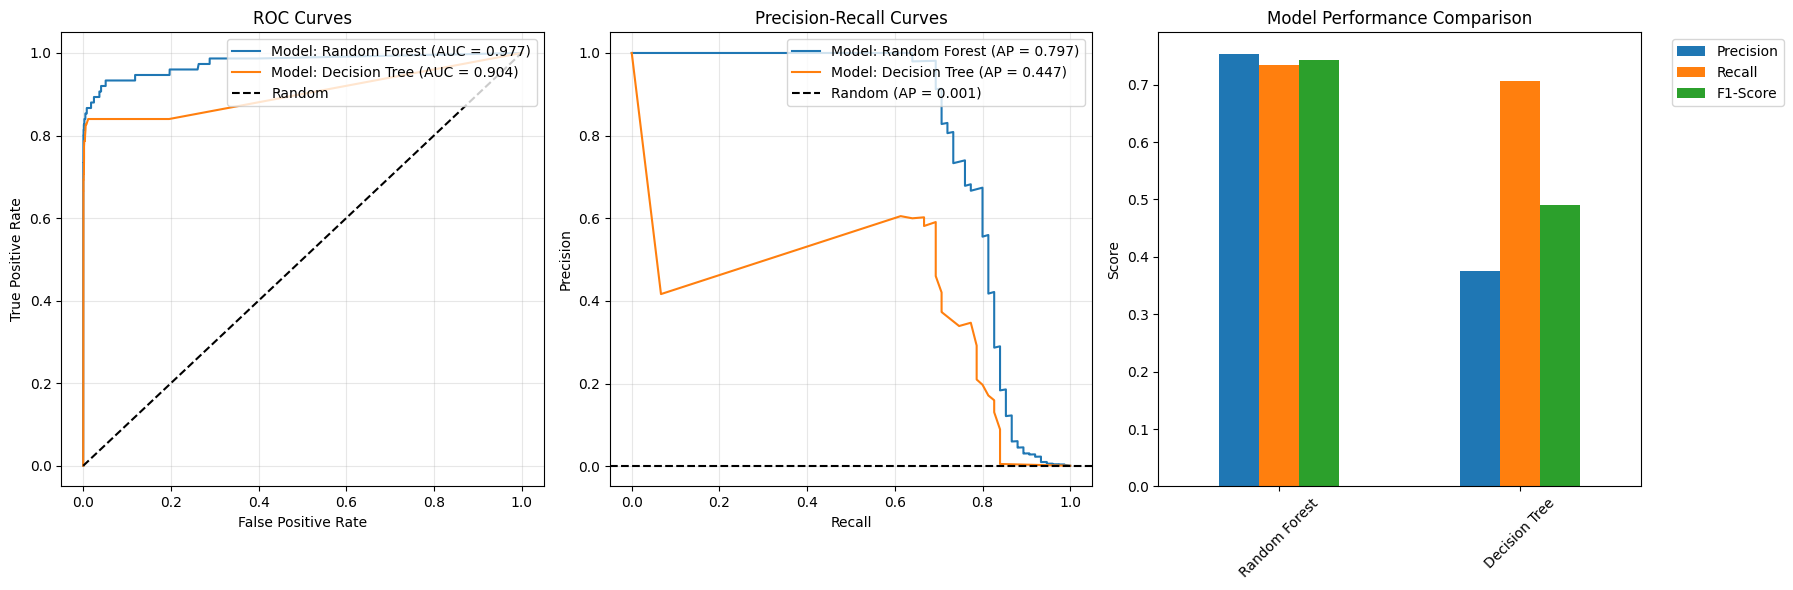

In [234]:
# ROC and Precision-Recall Curves
print(f"=== ROC AND PRECISION-RECALL CURVES ===")

# ROC Curves

fig, axes2 = plt.subplots(1,3,figsize=(18,6))
# calculate TPRs, FPRs and AUCs
for i, (model_name,model) in enumerate(tuned_models.items()):
    y_prob = model.predict_proba(X_test_scaled)[:,1]
    fpr,tpr,_ = roc_curve(y_test,y_prob)
    # print(fpr,tpr)
    auc_score = roc_auc_score(y_test,y_prob)
    # print(auc_score)
    # axes2[i].plot(fpr, tpr)
    # axes2[i].set_title(f"ROC Curve for {model_name}",fontweight='bold')
    # axes2[i].set_xlabel(f"False Positive Rates(FPR)")
    # axes2[i].set_ylabel(f"True Positive Rates(TPR)")
    axes2[0].plot(fpr,tpr,label = f"Model: {model_name} (AUC = {auc_score:.3f})")
axes2[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes2[0].set_xlabel('False Positive Rate')
axes2[0].set_ylabel('True Positive Rate')
axes2[0].set_title('ROC Curves')
axes2[0].legend(loc = 'upper right')
axes2[0].grid(True, alpha=0.3)

# Precision-Recall curves

for i, (model_name,model) in enumerate(tuned_models.items()):
    y_prob = model.predict_proba(X_test_scaled)[:,1]
    precision, recall, _ = precision_recall_curve(y_test,y_prob)
    avg_precision = average_precision_score(y_test,y_prob)
    axes2[1].plot(recall, precision, label = f"Model: {model_name} (AP = {avg_precision:.3f})")

# baseline
fraud_rate = y_test.sum()/len(y_test)
axes2[1].axhline(y=fraud_rate, color='k', linestyle='--', label=f'Random (AP = {fraud_rate:.3f})')
axes2[1].set_xlabel('Recall')
axes2[1].set_ylabel('Precision')
axes2[1].set_title('Precision-Recall Curves')
axes2[1].legend(loc = 'upper right')
axes2[1].grid(True, alpha=0.3)

# Performance Comparision

metrics_comparision = pd.DataFrame(final_results).T
metrics_comparision = metrics_comparision[['Precision','Recall','F1-Score']].copy()
metrics_comparision.plot(kind='bar', ax=axes2[2])
axes2[2].set_title('Model Performance Comparison')
axes2[2].set_ylabel('Score')
axes2[2].tick_params(axis='x', rotation=45)
axes2[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [227]:
metrics_comparision

,Precision,Recall,F1-Score
Random Forest,0.753425,0.733333,0.743243
Decision Tree,0.375887,0.706667,0.490741


=== THRESHOLD OPTIMIZATION ===
Optimizing threshold for Random Forest...
Optimal Threshold: 0.7


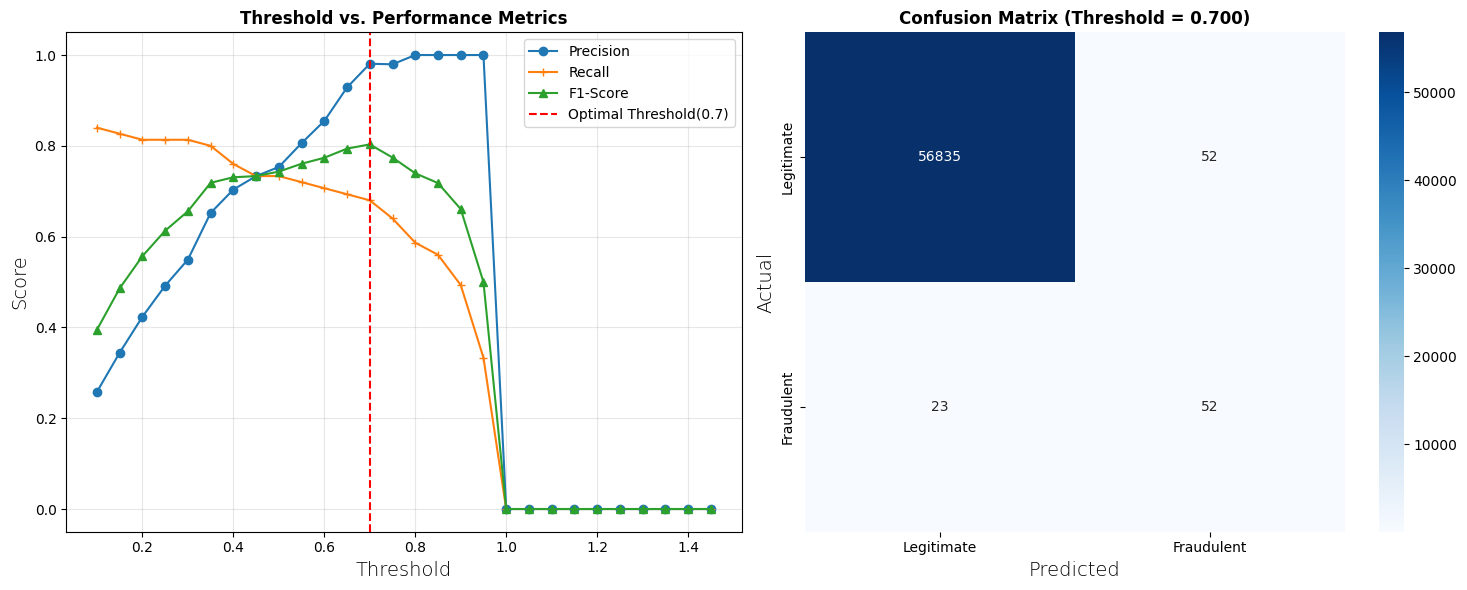

In [ ]:
# Threshold Optimization
print("=== THRESHOLD OPTIMIZATION ===")

# Select best model
best_model_name = max(final_results.keys(), key = lambda x: final_results[x]['F1-Score'])
best_model = tuned_models[best_model_name]

print(f"Optimizing threshold for {best_model_name}...")

# compute prediction probabilities
y_pred_prob = best_model.predict_proba(X_test_scaled)[:,1] # extracting probaility of being fraudulent transaction

# set different thresholds
thresholds = np.arange(0.1,1.5,0.05)
thresholds_results = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_prob >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    thresholds_results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

threshold_df = pd.DataFrame(thresholds_results)

# select best threshold based on F1-Score
optimal_threshold = threshold_df.loc[threshold_df['f1'].idxmax(),'threshold']
optimal_threshold = optimal_threshold.round(4)
print(f"Optimal Threshold: {optimal_threshold}")

# Plot for visualization

plt.figure(figsize=(15,6))

# Threshold vs. Performance Metrics
plt.subplot(1,2,1)
plt.plot(threshold_df['threshold'], threshold_df['precision'],marker='o',label='Precision')
plt.plot(threshold_df['threshold'], threshold_df['recall'],marker='+',label='Recall')
plt.plot(threshold_df['threshold'], threshold_df['f1'],marker='^',label='F1-Score')
plt.axvline(x = optimal_threshold, color='r', linestyle='--',label=f"Optimal Threshold({optimal_threshold})")
plt.legend()
plt.xlabel('Threshold',fontsize=14,fontweight='10')
plt.ylabel('Score',fontsize=14,fontweight='10')
plt.title('Threshold vs. Performance Metrics',fontweight='bold')
plt.grid(True, alpha=0.3)

# Performance at optimal threshold
y_pred_optimal = (y_prob>=optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

# plot heatmap
plt.subplot(1,2,2)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.title(f'Confusion Matrix (Threshold = {optimal_threshold:.3f})',fontweight='bold')
plt.ylabel('Actual',fontsize=14,fontweight='10')
plt.xlabel('Predicted',fontsize=14,fontweight='10')

plt.tight_layout()
plt.show()

In [356]:
# Final Model Selection
print("=== FINAL MODEL SELECTION ===")

# comparision with optimal threshold
final_comparision = final_results.copy()

cost_for_opt_thresh = (cm_optimal[0:1] * 500) + (cm_optimal[1:0] * 25)


precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)
roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
avg_precision = average_precision_score(y_test, y_prob) if y_prob is not None else None
cm = confusion_matrix(y_test, y_pred_optimal)
    
final_comparision[f'{best_model_name}_optimal_threshold'] = {
    'Precision': precision,
    'Recall': recall,
    "F1-Score": f1,
    "ROC-AUC": roc_auc,
    "Average Precision": avg_precision,
    "Cost Matrix": cm,
    "Cost 1": 500 * cm[1,0],
    "Cost 2": 25 * cm[0,1],
    "Total Cost": (500 * cm[1,0]) + (25 * cm[0,1])
}

# display(final_comparision)

# Create comparision dataframe
final_comparision_df = pd.DataFrame(final_comparision).T.round(4)
final_comparision_df = final_comparision_df.sort_values(by = 'F1-Score',ascending = False)

print("\n=== FINAL COMPARISION ===")
display(final_comparision_df)

print("\nSelecting the best model...")
# Select best model
best_model_final = final_comparision_df.index[0]
print(f"\nSELECTED BEST MODEL: {best_model_final}")
print(f"F1-Score: {final_comparision_df.loc[best_model_final, 'F1-Score']:.4f}")
print(f"Precision: {final_comparision_df.loc[best_model_final, 'Precision']:.4f}")
print(f"Recall: {final_comparision_df.loc[best_model_final, 'Recall']:.4f}")
print(f"Business Cost: ${final_comparision_df.loc[best_model_final, 'Total Cost']:,}")

=== FINAL MODEL SELECTION ===

=== FINAL COMPARISION ===


,Precision,Recall,F1-Score,ROC-AUC,Average Precision,Cost Matrix,Cost 1,Cost 2,Total Cost
Random Forest,0.753425,0.733333,0.743243,0.976566,0.797046,"[[56869, 18], [20, 55]]",500,9000,9500
Random Forest_optimal_threshold,0.5,0.693333,0.581006,0.903613,0.447266,"[[56835, 52], [23, 52]]",11500,1300,12800
Decision Tree,0.375887,0.706667,0.490741,0.903613,0.447266,"[[56799, 88], [22, 53]]",550,44000,44550



Selecting the best model...

SELECTED BEST MODEL: Random Forest
F1-Score: 0.7432
Precision: 0.7534
Recall: 0.7333
Business Cost: $9,500


In [ ]:
# Save best model and results
print("\n=== SAVING BEST MODEL ===")

# Save the best model
if 'optimal_threshold' in best_model_final:
    model_to_save = best_model
    threshold_to_save = optimal_threshold
else:
    model_to_save = tuned_models[best_model_final]
    threshold_to_save = 0.5

# Save model
joblib.dump(model_to_save, '../models/best_fraud_detection_model.pkl')
joblib.dump(scaler, '../models/feature_scaler.pkl')

# Save model metadata
model_metadata = {
    'model_name': best_model_final,
    'model_type': type(model_to_save).__name__,
    'features_used': top_features,
    'optimal_threshold': threshold_to_save,
    'performance_metrics': {
        'f1_score': float(final_comparision_df.loc[best_model_final, 'F1-Score']),
        'precision': float(final_comparision_df.loc[best_model_final, 'Precision']),
        'recall': float(final_comparision_df.loc[best_model_final, 'Recall']),
        'roc_auc': float(final_comparision_df.loc[best_model_final, 'ROC-AUC'])
    },
    'sampling_strategy': best_strategy,
    'training_date': pd.Timestamp.now().isoformat()
}

import numpy as np

with open('../models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)
with open('../models/performance_metrics_selected_models.json', 'w') as f:
    json.dump(convert_ndarray(final_results), f, indent=2)
with open('../models/performance_metrics_selected_models_baseline.json', 'w') as f:
    json.dump(convert_ndarray(baseline_model_results), f, indent=2)

print("Model saved successfully!")
print(f"Model file: models/best_fraud_detection_model.pkl")
print(f"Scaler file: models/feature_scaler.pkl") 
print(f"Metadata: models/model_metadata.json")
print(f"\nMODELING COMPLETE!")

print("="*100)
print("\n=== END OF MODELLING SCRIPT ===")


=== SAVING BEST MODEL ===
Model saved successfully!
Model file: models/best_fraud_detection_model.pkl
Scaler file: models/feature_scaler.pkl
Metadata: models/model_metadata.json

MODELING COMPLETE!

=== END OF MODELLING SCRIPT ===
